In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio
from numba import njit
from ipywidgets import interact, interactive
from scipy.signal import peak_widths, find_peaks
from scipy.interpolate import CubicSpline

plt.rcParams.update({"font.size" : 16, "font.family" : "serif", "figure.figsize" : (8,8)})

In [2]:
@njit
def ising_simulation_random(field, J1=1.0, J2=1.0, p=0.5, T=1.0, maxiter=int(1e7)):
    #init
    n = field.shape[0]
    
    #to flip or not to flip
    rand_positions = np.random.randint(low=0, high=n, size=2*maxiter).reshape(-1, 2)
    rand_decision = np.random.random(maxiter)
    
    #probabilities
    probs = np.random.random(maxiter)

    #Ising steps, Monte-Carlo
    for idx in range(maxiter):
        i, j = rand_positions[idx]
        #nearest neighbours
        energy1 = -J1*field[i, j] * (field[i, (j+1)%n] + field[i, (j-1)%n] + field[(i+1)%n,j] + field[(i-1)%n,j])
        #diagonal neighbours
        energy2 = -J2*field[i, j] * (field[(i+1)%n, (j+1)%n] + field[(i-1)%n, (j+1)%n] + field[(i+1)%n, (j-1)%n] +
                                    +field[(i-1)%n, (j-1)%n])
        #with probability 1-p flip sign of J2 interaction
        if probs[idx] > p:
            energy2 = -energy2
        
        #total energy
        energy = energy1 + energy2

        #Monte-Carlo single-flip step
        if energy > 0 or rand_decision[idx] < np.exp(2*energy/T):
            field[i, j] = -field[i, j]
                
    return field


def corr2d(field):
    n = field.shape[0]
    temp = np.fft.fft2(field)
    res = np.real(np.fft.ifft2(temp * np.conjugate(temp)))
    res /= np.max(res)
    res = np.vstack((np.hstack((res[n//2:, n//2:], res[n//2:, :n//2])), np.hstack((res[:n//2, n//2:], res[:n//2, :n//2]))))
    
    res_slice = res[::,n//2]
    cs1 = CubicSpline(np.arange(0, len(res_slice),2), res_slice[::2])
    cs2 = CubicSpline(np.arange(1, len(res_slice),2), res_slice[1::2])
    res_slice1 = cs1(np.arange(len(res_slice)))
    res_slice2 = cs2(np.arange(len(res_slice)))
    
    res_slice = np.max(np.vstack([res_slice1, res_slice2]), axis=0)
    
    return res_slice


def corr_diam(field):
    temp = corr2d(field)
    peaks, _ = find_peaks(temp, height=0.75)
    results_half = peak_widths(temp, peaks, rel_height=0.5)
    return results_half[0][0]

In [641]:
n = 500
T = np.linspace(0.06, 6.0, 101)[::-1]
P = np.linspace(0.0, 1.0, 201)

correlations = []

for prob in P:
    field = 2 * np.random.randint(low=0, high=2, size=(n,n)) - 1
    temp = []
    for t in T:
        field = ising_simulation_random(field, T=t, p=prob, maxiter=int(1e7))
        temp.append(corr_diam(field))
    
    temp = np.array(temp)
    correlations.append(temp)

Text(0, 0.5, 'kT/J1')

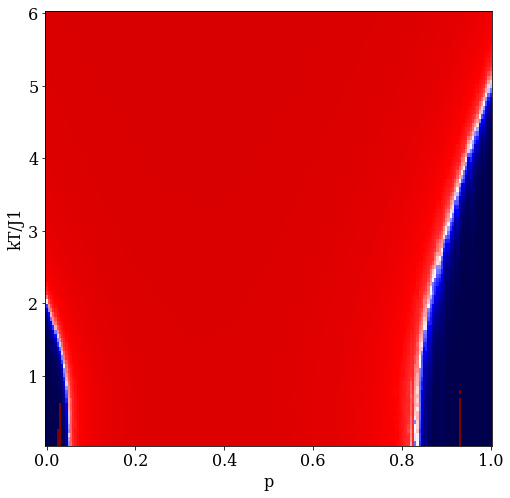

In [742]:
plt.figure(figsize=(8,8))
pt, Tt = np.meshgrid(P, T)
Z = np.array(correlations).T
# plt.pcolormesh(pt, Tt, 1-(0.5-np.exp(-0.1*Z))**2, cmap='seismic')
plt.pcolormesh(pt, Tt,np.exp(-0.1*Z), cmap='seismic')
plt.xlabel("p")
plt.ylabel("kT/J1")


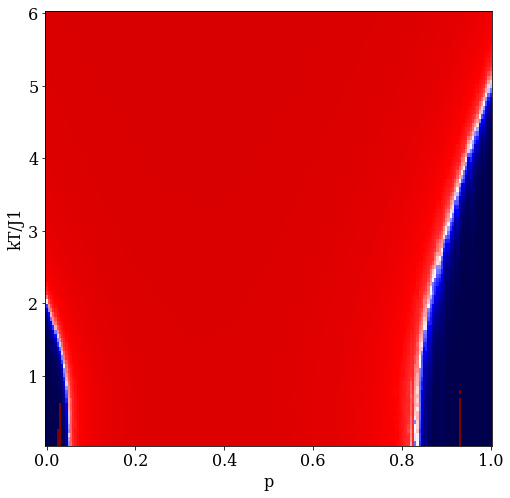

In [767]:
plt.figure(figsize=(8,8))
pt, Tt = np.meshgrid(P, T)
Z = np.array(correlations).T
# plt.pcolormesh(pt, Tt, 1-(0.5-np.exp(-0.1*Z))**2, cmap='seismic')
plt.pcolormesh(pt, Tt,np.exp(-0.1*Z), cmap='seismic')
plt.xlabel("p")
plt.ylabel("kT/J1")
plt.savefig("/Users/goloshch/Desktop/pic6.png", dpi=150)

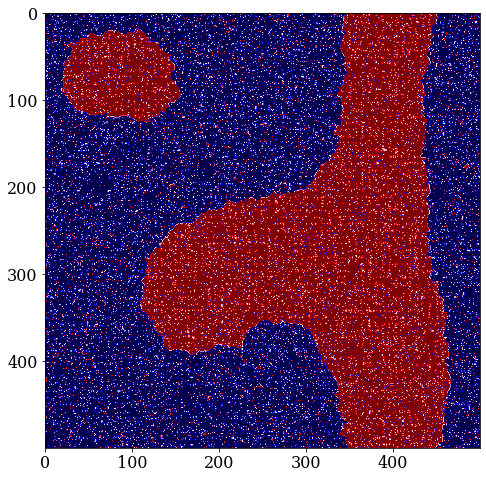

In [746]:
field = ising_simulation_random(field, T=1, p=0.9, maxiter=int(1e7))
plt.imshow(field, cmap='seismic')

(-0.5, 199.5, 199.5, -0.5)

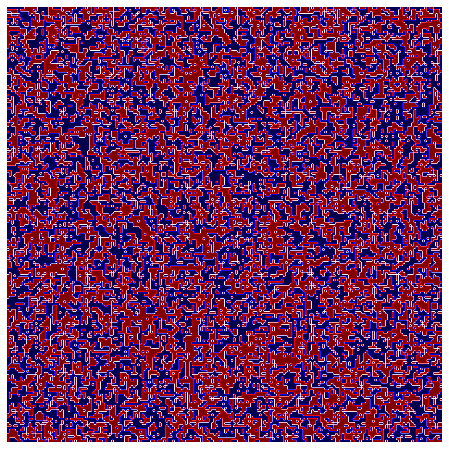

In [757]:
field = ising_simulation_random(field, T=1, p=0.5, maxiter=int(1e7))
plt.imshow(field[:200,:200], cmap='seismic')
plt.axis('off')

(-0.5, 199.5, 199.5, -0.5)

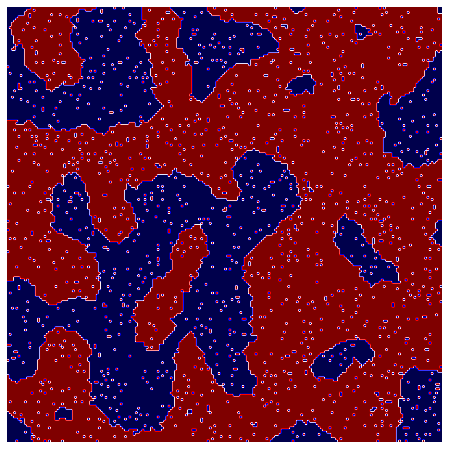

In [759]:
field = ising_simulation_random(field, T=1, p=0.95, maxiter=int(1e7))
plt.imshow(field[:200,:200], cmap='seismic')
plt.axis('off')

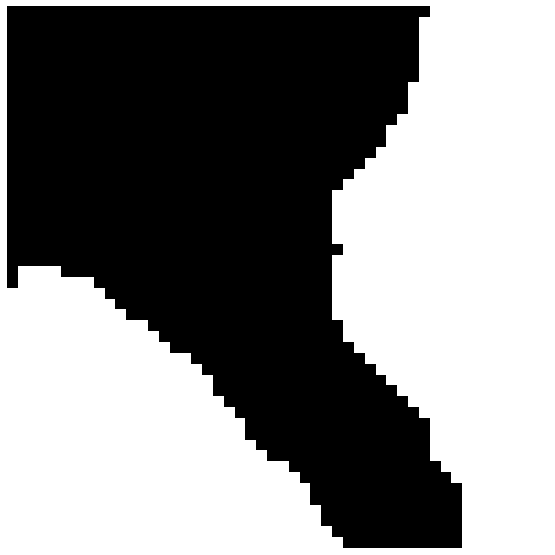

In [766]:
pim = [0.0, 0.05, 0.5, 0.95, 1.0]

i = 1
for p in pim:
    field = ising_simulation_random(field, T=1, p=p, maxiter=int(1e7))
    plt.imshow(field[:50,:50], cmap='binary')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("/Users/goloshch/Desktop/pic{}.png".format(i), dpi=50)
    i+=1